# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [38]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [39]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if all(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    #sanitized_instruction = tokenizer(d['high_descs'][i])
                    #sanitized_instruction = filter(lambda x: not x in string.punctuation,sanitized_instruction)
                    #sanitized_instruction = [wnl.lemmatize(word) for word in sanitized_instruction]
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████| 255/255 [00:02<00:00, 90.20it/s]


In [61]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(str(index))
    
    def index(self, word):
        return self.word2index.get(word)
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

lang.add_sentence(["<SOS>", "<EOS>"])
action_lang.add_sentence(["<SOS>", "<EOS>"])
argument_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                    argument_lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                    argument_lang.add_word(instruction_arg_2)
                
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths
                    
sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')
argument_lang.dump('argument_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))
print('number of arguments = ', argument_lang.n_words)

print(action_lang.word2index)
print(argument_lang.word2index)

100%|█████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 5183.65it/s]

average sentence length = 9.84 words
vocab size = 1947
most common words:  [('the', 314034), ('to', 88329), ('turn', 65997), ('and', 60512), ('on', 51078), ('of', 50848), ('right', 40425), ('left', 39517), ('in', 33950), ('a', 30771)]
most common actions:  [('GotoLocation', 62568), ('PickupObject', 28419), ('PutObject', 26162), ('CoolObject', 2761), ('SliceObject', 2737), ('HeatObject', 2727), ('CleanObject', 2603), ('ToggleObject', 2166), ('<SOS>', 1), ('<EOS>', 1)]
number of arguments =  83
{'<SOS>': 0, '<EOS>': 1, 'GotoLocation': 2, 'PickupObject': 3, 'ToggleObject': 4, 'PutObject': 5, 'SliceObject': 6, 'CleanObject': 7, 'CoolObject': 8, 'HeatObject': 9}
{'<SOS>': 0, '<EOS>': 1, 'dresser': 2, 'alarmclock': 3, 'desklamp': 4, 'desk': 5, 'shelf': 6, 'sidetable': 7, 'baseballbat': 8, 'basketball': 9, 'book': 10, 'bed': 11, 'bowl': 12, 'sofa': 13, 'box': 14, 'coffeetable': 15, 'diningtable': 16, 'floorlamp': 17, 'candle': 18, 'cd': 19, 'drawer': 20, 'garbagecan': 21, 'cellphone': 22, 'ar

In [45]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                train_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action / argument pairs =', len(train_low_action_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                eval_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action / argument pairs =', len(eval_low_action_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_argument_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, [rpair[0], rpair[1]]))

100%|████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 31750.41it/s]

train reconstruction samples = 144336
train high -> low pairs = 125571
train low -> action / argument pairs = 125571
eval reconstruction samples = 5304
eval high -> low pairs = 4572
eval low -> action / argument pairs = 4572
using device: cuda
[['pick', 'up', 'the', 'box', 'from', 'the', 'couch'], ['PickupObject'], ['box']]
(tensor([[  2],
        [  3],
        [  4],
        [158],
        [ 14],
        [  4],
        [185],
        [  1]], device='cuda:0'), tensor([[3],
        [1]], device='cuda:0'))


# Model

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 10

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Train - Action Decoder

In [105]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 1
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(action_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[1]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     action_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_decoder.state_dict(), 'action_decoder.pt')

show_plot(plot_losses)

updates:  54434
tensor([[-1.3582e+01, -1.4300e+01, -1.7508e-03, -6.4714e+00, -1.4388e+01,
         -8.6142e+00, -1.1047e+01, -1.4340e+01, -1.3927e+01, -1.4053e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


AssertionError: 

# Train - Argument Decoder

updates:  54434
0m 0s (- 9m 2s) (100 0%) 0.3633
0m 1s (- 8m 50s) (200 0%) 0.2878
0m 2s (- 8m 46s) (300 0%) 0.4168
0m 3s (- 8m 42s) (400 0%) 0.3692
0m 4s (- 8m 40s) (500 0%) 0.0903
0m 5s (- 8m 35s) (600 1%) 0.1787
0m 6s (- 8m 36s) (700 1%) 0.1883
0m 7s (- 8m 35s) (800 1%) 0.2301
0m 8s (- 8m 32s) (900 1%) 0.3606
0m 9s (- 8m 31s) (1000 1%) 0.1761
0m 10s (- 8m 30s) (1100 2%) 0.2242
0m 11s (- 8m 28s) (1200 2%) 0.3677
0m 12s (- 8m 27s) (1300 2%) 0.3670
0m 13s (- 8m 27s) (1400 2%) 0.2338
0m 14s (- 8m 24s) (1500 2%) 0.1344
0m 15s (- 8m 23s) (1600 2%) 0.2391
0m 16s (- 8m 22s) (1700 3%) 0.1021
0m 17s (- 8m 20s) (1800 3%) 0.0439
0m 18s (- 8m 18s) (1900 3%) 0.2558
0m 18s (- 8m 17s) (2000 3%) 0.3821
0m 19s (- 8m 16s) (2100 3%) 0.2048
0m 20s (- 8m 14s) (2200 4%) 0.3511
0m 21s (- 8m 14s) (2300 4%) 0.2788
0m 22s (- 8m 13s) (2400 4%) 0.2011
0m 23s (- 8m 12s) (2500 4%) 0.1322
0m 24s (- 8m 11s) (2600 4%) 0.0533
0m 25s (- 8m 10s) (2700 4%) 0.0654
0m 26s (- 8m 9s) (2800 5%) 0.2696
0m 27s (- 8m 8s) (2900 5%

3m 56s (- 5m 26s) (22900 42%) 0.3787
3m 58s (- 5m 25s) (23000 42%) 0.0654
3m 59s (- 5m 24s) (23100 42%) 0.1429
4m 0s (- 5m 23s) (23200 42%) 0.2813
4m 1s (- 5m 22s) (23300 42%) 0.2926
4m 2s (- 5m 21s) (23400 42%) 0.4363
4m 3s (- 5m 20s) (23500 43%) 0.7924
4m 4s (- 5m 19s) (23600 43%) 0.1620
4m 5s (- 5m 18s) (23700 43%) 0.2082
4m 6s (- 5m 17s) (23800 43%) 0.2701
4m 7s (- 5m 16s) (23900 43%) 0.2958
4m 8s (- 5m 14s) (24000 44%) 0.2874
4m 9s (- 5m 13s) (24100 44%) 0.3274
4m 10s (- 5m 12s) (24200 44%) 0.3346
4m 11s (- 5m 11s) (24300 44%) 0.1973
4m 12s (- 5m 10s) (24400 44%) 0.1528
4m 13s (- 5m 9s) (24500 45%) 0.2010
4m 14s (- 5m 8s) (24600 45%) 0.0933
4m 15s (- 5m 7s) (24700 45%) 0.3535
4m 16s (- 5m 6s) (24800 45%) 0.2439
4m 17s (- 5m 5s) (24900 45%) 0.1138
4m 18s (- 5m 4s) (25000 45%) 0.1002
4m 19s (- 5m 3s) (25100 46%) 0.2561
4m 20s (- 5m 2s) (25200 46%) 0.3567
4m 21s (- 5m 1s) (25300 46%) 0.3931
4m 22s (- 5m 0s) (25400 46%) 0.1807
4m 23s (- 4m 59s) (25500 46%) 0.0721
4m 24s (- 4m 58s) (25

409m 44s (- 100m 38s) (43700 80%) 0.2788
409m 45s (- 99m 29s) (43800 80%) 0.2518
409m 47s (- 98m 19s) (43900 80%) 0.3294
409m 48s (- 97m 10s) (44000 80%) 0.2053
409m 49s (- 96m 1s) (44100 81%) 0.3764
409m 50s (- 94m 53s) (44200 81%) 0.3369
409m 51s (- 93m 45s) (44300 81%) 0.3755
409m 52s (- 92m 37s) (44400 81%) 0.3669
409m 53s (- 91m 30s) (44500 81%) 0.1139
409m 54s (- 90m 22s) (44600 81%) 0.0181
409m 55s (- 89m 15s) (44700 82%) 0.5726
409m 56s (- 88m 9s) (44800 82%) 0.1809
409m 57s (- 87m 2s) (44900 82%) 0.1328
409m 58s (- 85m 56s) (45000 82%) 0.2179
409m 59s (- 84m 51s) (45100 82%) 0.2138
410m 0s (- 83m 45s) (45200 83%) 0.3173
410m 1s (- 82m 40s) (45300 83%) 0.1450
410m 2s (- 81m 35s) (45400 83%) 0.2957
410m 3s (- 80m 30s) (45500 83%) 0.1858
410m 4s (- 79m 26s) (45600 83%) 0.1938
410m 5s (- 78m 22s) (45700 83%) 0.3168
410m 6s (- 77m 18s) (45800 84%) 0.2243
410m 8s (- 76m 15s) (45900 84%) 0.1935
410m 9s (- 75m 12s) (46000 84%) 0.1561
410m 10s (- 74m 9s) (46100 84%) 0.0637
410m 11s (- 

<Figure size 432x288 with 0 Axes>

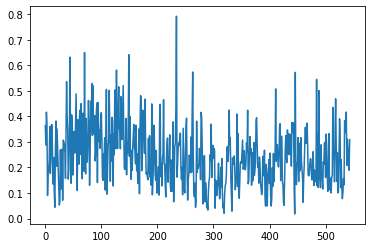

In [69]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 1
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(argument_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[2]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(argument_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     argument_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(argument_decoder.state_dict(), 'argument_decoder.pt')

show_plot(plot_losses)

# Eval

In [70]:
def evaluate(encoder, decoder, sentence, encoder_lang, decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(decoder_lang.word(topi.item()))

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    decoder.load_state_dict(torch.load('action_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, decoder, sample[0], lang, action_lang)
    print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output[0]} ({output[0][0] == sample[1][0]})")
    results.append(output[0][0] == sample[1][0])

samples: 1939
turn to the left and face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the clock that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left then face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the alarm clock on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
pick up the clock on the desk top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk to face right side of desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up red and grey bottle from desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to desk on right side of room (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on lamp on the desk (ToggleObject) -> ['PutObject', '<EOS>'] (False)
use the metal box to turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)

pick up the open box from the bottom shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the light (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp that is to your left (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk forward turn right to face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cd that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn the lamp on (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk to the right side of the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
locate the lamp on the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
pick up the disc on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and then turn back to the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the lam

turn right and head towards the cupboard (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cupboard and take out the newspaper (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left towards the standing light (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the standing light (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lap (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
go to the desk on your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab a pencil from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn the lamp on (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn to the right and face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick the pencil up from the desk (PickupObject) -> ['Pi

place the salt in the cabinet under the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
look up to see the cabinet at the top (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
move to the counter left of the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the salt from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
bring salt up the the cabinet above the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the salt shaker from the counter top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left and walk in front of the oven (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open cabinet pick up salt from cabinet close cabinet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place salt in second drawer close drawer (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the salt shaker from the kitchen island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move left then right around the kitchen island (GotoLocation) -> ['Go

turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the glass with the knife inside the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the butter knife from beneath the sponge (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
grab the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around to the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the pan on the stove (PutObject) -> ['PutObject', '<EOS>'] (True)
grab the pan with the knife (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and take the 

put the green cup in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the fork next to the tomato (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the fork in the green cup (PutObject) -> ['PutObject', '<EOS>'] (True)
turn right then left back to the cabinet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cabinet above the coffee maker (PutObject) -> ['GotoLocation', '<EOS>'] (False)
turn left towards the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the glass vase in the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right to the cupboard and open them (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the glass vase on the gold plate (PutObject) -> ['PutObject', '<EOS>'] (True)
take them out of the cupboard (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and towards the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the vase and plate in the sink (PutObject) -> ['PutObject', '<EOS>'] (True

pick up the spoon on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the plate with the spoon on it (PickupObject) -> ['PickupObject', '<EOS>'] (True)
wash the bowl in the sink (CleanObject) -> ['CleanObject', '<EOS>'] (True)
pick up the dirty bowl on the island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around bring the bowl to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
fill the bowl with water from the sink (CleanObject) -> ['GotoLocation', '<EOS>'] (False)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn back around (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and move left to the toaster (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
wash the bowl in the sink (CleanObject) -> ['CleanObject',

look down to face the lettuce on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the lettuce on the counter into slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the knife in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the slice of lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the lettuce slice in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
look down at the lettuce on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the lettuce on the counter (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn right and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up a slice of lettuce (PickupObject) 

place the plate on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
turn and go to the counter by the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a dirty plate on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
wash the dish in the sink (CleanObject) -> ['CleanObject', '<EOS>'] (True)
turn and go to the counter by the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the plate on the counter by the stove (PutObject) -> ['PutObject', '<EOS>'] (True)
move back slightly away from the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around to face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around facing sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up bar of soap (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around take one step turn around (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk over t

pick up the head of lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk left back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
chill the lettuce in the fridge (CoolObject) -> ['SliceObject', '<EOS>'] (False)
pick up the lettuce off of the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the lettuce down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the lettuce from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the lettuce to the refrigerator (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the lettuce on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left to face counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn left walk to fridge turn right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn right walk forward turn left to face counter (GotoLocation) -> ['

pick up the pan on the stove (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk left back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk a few step right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
go left and stand in front of the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the pan on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
take a step to your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the pan on the front left burner (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the pan on the front left burner (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left to carry the pan to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan on the counter top (PutObject) -> ['PutObject', '<EOS>'] (True)
grab a pan from the stove (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the pan in the fridge then grab it (CoolObject) -> ['PickupObject', '<EOS>'] (False)
plac

pick up the knife from the center island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to the counter next to the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the tomato on the counter with the knife (SliceObject) -> ['SliceObject', '<EOS>'] (True)
take the knife to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the fridge (PutObject) -> ['PutObject', '<EOS>'] (True)
go back to the tomato slice on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a tomato slice from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the tomato to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
set the tomato slice down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
slice the tomato (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife down in front of the keurig (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the right end of the tomato (PickupObject) -> ['PickupObjec

take two step to the right to face stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the apple slice on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple in the bin in to section (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife in the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up a section of apple (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left move to in front of the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the cooked apple section in the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the butter knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
slice the apple in the trash can (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the butter knife in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and go to the microwave (GotoLocation) -> ['GotoLocation',

heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cabinet and place the cup inside (PutObject) -> ['PutObject', '<EOS>'] (True)
take a few step right to the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the coffee mug on the coffee maker (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the mug out of the coffee maker (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk to face coffee maker (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
remove mug from inside coffee maker (PickupObject) -> ['Picku

turn left and go to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the tomato from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the tomato inside of the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick the tomato up from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the microwave above the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the tomato in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the tomato from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and look up (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the tomato in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the tomato from the kitchen island (PickupObject) -> ['PickupObject', '<EOS>'] (Tr

turn left and head to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the apple out of the trash can (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and head to the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the apple down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife off of the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple into three slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn around and stop at the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the apple in the sink into three slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife into the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
grab one of the apple slice (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the apple slice on the counter (PutObject) -> ['PutObject', '<EOS>'] (True

walk to face white couch (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up key from couch (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to face small white safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put key inside safe (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around then face the couch to your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the key in the safe on the floor (PutObject) -> ['PutObject', '<EOS>'] (True)
place the key in the safe on the floor (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around go to the white sofa (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the key-chain from the sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick the key-chain from that sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
go back to the safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the key-chain inside the safe and close it (PutObject) -> ['PutObject', '<EOS>'] (True)
place the key in the

go to the toilet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and go to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and go to the toilet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab a bar of soap off of the toilet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and go to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left and face the back of the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
place the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
move towards toilet to the right of the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up toilet roll from off the toilet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move

In [73]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.9004641567818463


# Eval Action / Arguments

In [101]:
def evaluate(encoder, action_decoder, argument_decoder, sentence, encoder_lang, action_decoder_lang, argument_decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action Decoder
        action_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        action_decoder_hidden = encoder_hidden
        action_decoded_words = []
        action_decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, action_decoder_hidden, decoder_attention = action_decoder(
                action_decoder_input, action_decoder_hidden, encoder_outputs)
            action_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                action_decoded_words.append('<EOS>')
                break
            else:
                action_decoded_words.append(action_decoder_lang.word(topi.item()))
        
            action_decoder_input = topi.squeeze().detach()
        
        # Argument Decoder
        argument_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        argument_decoder_hidden = encoder_hidden
        argument_decoded_words = []
        argument_decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, argument_decoder_hidden, decoder_attention = argument_decoder(
                argument_decoder_input, argument_decoder_hidden, encoder_outputs)
            argument_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                argument_decoded_words.append('<EOS>')
                break
            else:
                argument_decoded_words.append(argument_decoder_lang.word(topi.item()))

            argument_decoder_input = topi.squeeze().detach()

        return action_decoded_words, argument_decoded_words

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, action_decoder, argument_decoder, sample[0], lang, action_lang, argument_lang)
    arg_result = output[1][0] == sample[2][0]
    if len(sample[2]) > 1:
        arg_result &= output[1][1] == sample[2][1]
    print(output[1][:-1], sample[2])
    results.append(output[0][0] == sample[1][0] and arg_result)

samples: 1939
['shelf'] ['desk']
['alarmclock'] ['alarmclock']
['diningtable'] ['desk']
['alarmclock'] ['alarmclock']
['floorlamp'] ['desklamp']
['watch'] ['alarmclock']
['floorlamp'] ['desklamp']
['shelf'] ['desk']
['winebottle'] ['alarmclock']
['shelf'] ['desklamp']
['diningtable'] ['desklamp']
['sidetable'] ['desklamp']
['alarmclock'] ['alarmclock']
['diningtable'] ['desklamp']
['shelf'] ['baseballbat']
['wateringcan'] ['baseballbat']
['shelf'] ['desklamp']
['wateringcan'] ['baseballbat']
['floorlamp'] ['desklamp']
['shelf'] ['baseballbat']
['wateringcan'] ['baseballbat']
['shelf'] ['desklamp']
['diningtable'] ['desklamp']
['shelf'] ['baseballbat']
['wateringcan'] ['baseballbat']
['shelf'] ['desklamp']
['diningtable'] ['desklamp']
['wateringcan'] ['baseballbat']
['diningtable'] ['desklamp']
['wateringcan'] ['baseballbat']
['floorlamp'] ['desklamp']
['shelf'] ['baseballbat']
['wateringcan'] ['baseballbat']
['diningtable'] ['desklamp']
['wateringcan'] ['baseballbat']
['floorlamp'] ['d

['pencil', 'shelf'] ['pencil', 'shelf']
['pencil'] ['pencil']
['shelf'] ['desk']
['pencil'] ['pencil']
['shelf'] ['shelf']
['saltshaker'] ['peppershaker']
['winebottle'] ['peppershaker']
['toiletpaper', 'drawer'] ['peppershaker', 'drawer']
['saltshaker'] ['peppershaker']
['saltshaker'] ['peppershaker']
['countertop'] ['countertop']
['winebottle'] ['peppershaker']
['coffeetable'] ['countertop']
['countertop'] ['countertop']
['toiletpaper'] ['peppershaker']
['countertop'] ['drawer']
['saltshaker'] ['peppershaker']
['drawer'] ['countertop']
['saltshaker'] ['peppershaker']
['cabinet'] ['drawer']
['saltshaker'] ['peppershaker']
['toilet'] ['plunger']
['toiletpaper'] ['plunger']
['cabinet'] ['cabinet']
['toiletpaper', 'cabinet'] ['plunger', 'cabinet']
['wateringcan'] ['plunger']
['dresser'] ['cabinet']
['sinkbasin'] ['plunger']
['cabinet'] ['cabinet']
['toilet'] ['plunger']
['toiletpaper'] ['plunger']
['shelf'] ['cabinet']
['toilet'] ['plunger']
['shelf'] ['shelf']
['vase'] ['saltshaker']
['

['pencil', 'garbagecan'] ['pencil', 'bowl']
['bowl'] ['bowl']
['pencil'] ['pencil']
['bowl'] ['bowl']
['vase', 'shelf'] ['bowl', 'shelf']
['pencil'] ['pencil']
['pencil', 'shelf'] ['pencil', 'bowl']
['bowl'] ['bowl']
['bowl', 'shelf'] ['bowl', 'shelf']
['shelf'] ['desk']
['pencil'] ['pencil']
['shelf'] ['bowl']
['pencil', 'shelf'] ['pencil', 'bowl']
['spoon'] ['spoon']
['mug'] ['mug']
['mug', 'sidetable'] ['mug', 'countertop']
['spoon'] ['spoon']
['vase'] ['mug']
['fridge'] ['mug']
['countertop'] ['mug']
['spoon', 'fridge'] ['spoon', 'mug']
['countertop'] ['countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['winebottle'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['mug'] ['mug']
['countertop'] ['countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['spoon', 'drawer'] ['spoon', 'mug']
['mug'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['fridge'] ['mug']
['vase'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['spoon'] ['spoo

['toiletpaper'] ['soapbar']
['sinkbasin'] ['countertop']
['toiletpaper'] ['soapbar']
['wateringcan'] ['soapbar']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['sinkbasin'] ['countertop']
['toiletpaper'] ['soapbar']
['garbagecan'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['toiletpaper'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper'] ['soapbar']
['sinkbasin'] ['sinkbasin']
['toiletpaper', 'sinkbasin'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['countertop'] ['countertop']
['soapbar'] ['soapbar']
['sinkbasin'] ['sinkbasin']
['shelf'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['sinkbasin'] ['countertop']
['toiletpaper'] ['soapbar']
['countertop'] ['sinkbasin']
['toiletpaper'] ['soapbar']
['shelf'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['countertop'] ['countertop']
['spatula'] ['spatula']
['sinkbasin'] ['sinkbasin']
['dress

['countertop'] ['sinkbasin']
['tomato'] ['tomato']
['knife'] ['knife']
['tomato'] ['tomato']
['tomato'] ['tomato']
['fridge'] ['fridge']
['countertop'] ['countertop']
['knife'] ['knife']
['countertop'] ['tomato']
['tomato'] ['tomato']
['knife', 'countertop'] ['knife', 'countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['tomato'] ['tomato']
['countertop'] ['countertop']
['tomato', 'countertop'] ['tomato', 'countertop']
['diningtable'] ['countertop']
['knife'] ['knife']
['diningtable'] ['tomato']
['tomato'] ['tomato']
['knife', 'sidetable'] ['knife', 'countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['diningtable'] ['countertop']
['bread', 'sidetable'] ['tomato', 'countertop']
['knife'] ['butterknife']
['tomato'] ['tomato']
['fridge'] ['fridge']
['butterknife', 'fridge'] ['butterknife', 'fridge']
['countertop'] ['countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['countertop'] ['countertop']
['tomato', 'countertop'] ['tomato', 'countertop']
['fridge'] ['fridge']
['c

['potato'] ['potato']
['potato', 'garbagecan'] ['potato', 'garbagecan']
['knife'] ['butterknife']
['potato'] ['potato']
['knife', 'garbagecan'] ['butterknife', 'garbagecan']
['potato', 'fridge'] ['potato', 'fridge']
['knife'] ['butterknife']
['potato'] ['potato']
['knife', 'garbagecan'] ['butterknife', 'garbagecan']
['stoveburner'] ['microwave']
['fridge'] ['fridge']
['butterknife'] ['butterknife']
['knife', 'garbagecan'] ['butterknife', 'garbagecan']
['potato', 'fridge'] ['potato', 'fridge']
['diningtable'] ['countertop']
['knife'] ['butterknife']
['fridge'] ['potato']
['potato'] ['potato']
['shelf'] ['shelf']
['knife', 'shelf'] ['butterknife', 'shelf']
['fridge'] ['fridge']
['potato'] ['potato']
['stoveburner'] ['microwave']
['fridge'] ['fridge']
['lettuce', 'fridge'] ['potato', 'fridge']
['knife'] ['butterknife']
['shelf'] ['shelf']
['knife', 'shelf'] ['butterknife', 'shelf']
['fridge'] ['fridge']
['potato'] ['potato']
['potato', 'fridge'] ['potato', 'fridge']
['fridge'] ['potato']


['armchair'] ['armchair']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow', 'sofa'] ['pillow', 'sofa']
['armchair'] ['armchair']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow', 'sofa'] ['pillow', 'sofa']
['pillow'] ['pillow']
['toiletpaperhanger'] ['armchair']
['pillow'] ['pillow']
['sidetable'] ['sofa']
['pillow'] ['pillow']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow', 'dresser'] ['pillow', 'sofa']
['pillow'] ['pillow']
['armchair'] ['armchair']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow'] ['pillow']
['armchair'] ['armchair']
['pillow'] ['pillow']
['pillow'] ['pillow']
['pillow'] ['pillow']
['armchair'] ['armchair']
['toiletpaper'] ['soapbar']
['toilet'] ['toilet']
['toiletpaper'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper'] ['soapbar']
['cabinet'] ['cabinet']
['countertop'] ['countertop']
['cabinet'] ['cabinet']
['drawer'] ['cabinet']
['toiletpaper'] ['soapbar']
['drawer'] ['cabinet']
['sinkbasin'] ['countertop']
['cabinet'] ['cabinet']
['countertop'] ['c

In [102]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.5317173800928313
